In [1]:
import json
import os

%load_ext dotenv
%dotenv

# f = open("authPaper.json")
# auth = json.load(f)

In [6]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
# BASE_URL = "https://paper-api.alpaca.markets"
# API_KEY = auth['ID']
# SECRET_KEY = auth['Secret']

In [3]:
api = tradeapi.REST(key_id= os.getenv('API_KEY'), secret_key=os.getenv('SECRET_KEY'), base_url=os.getenv('APCA_API_BASE_URL'), api_version='v2')

In [11]:
import talib as tb

In [48]:
df_apple = api.get_bars("AAPL", TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df

In [49]:
macd, macdsignal, macdhist = tb.MACD(df_apple['close'], fastperiod=12, slowperiod=26, signalperiod=9)

<AxesSubplot:xlabel='timestamp'>

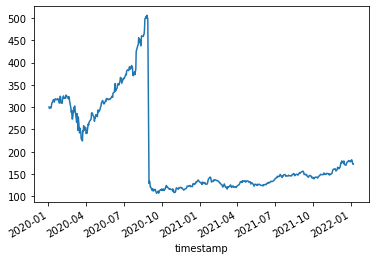

In [175]:
df_apple['close'].plot()

In [85]:
# importing forecasting libraries
import pmdarima as pm
import numpy as npf
import matplotlib.pyplot as plt
import seaborn as sn

In [72]:
arima_model = pm.auto_arima(df_apple['close'], seasonal = False)

# Random Walk (Useless)
A random walk does not help predict the next values only that the variance will increase... lame <br>
This is for predictions involving the closing cost

In [73]:
arima_model

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Forecasting Volume

We can see that volume is dependant on on previous lag with a ar and ma term.

In [74]:
arima_model = pm.auto_arima(df_apple['volume'], seasonal = False)

arima_model

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Correlation plot

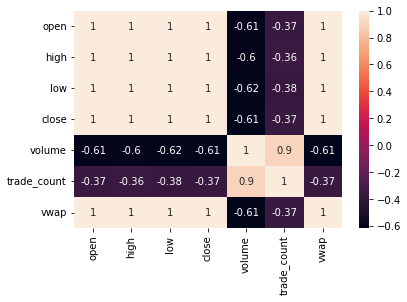

In [75]:
corrMatrix = df_apple.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [171]:
# building  linear model
import statsmodels.api as sm
import math
from scipy import stats
from scipy import special

In [ ]:
# build a function that can take in a stock, apply a transformation on it, forecast it and test it as well.

In [177]:
stock = "AAPL"
test_set_length = 30

In [263]:
df_bars = api.get_bars(stock, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df

In [264]:
df_bars

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2020-01-02 05:00:00+00:00,296.27,300.6000,295.190,300.350,33920004,283490,298.439935
2020-01-03 05:00:00+00:00,296.95,300.5800,296.500,297.430,36633995,280942,298.810386
2020-01-06 05:00:00+00:00,293.70,299.9600,292.750,299.800,29644779,242867,297.799601
2020-01-07 05:00:00+00:00,299.98,300.9000,297.480,298.390,27885664,227873,298.924596
2020-01-08 05:00:00+00:00,297.17,304.4399,297.156,303.190,33091741,261777,301.165533
...,...,...,...,...,...,...,...
2022-01-03 05:00:00+00:00,177.81,182.8800,177.710,182.010,104690466,772367,181.415512
2022-01-04 05:00:00+00:00,182.61,182.9400,179.120,179.700,99284337,831619,180.555450
2022-01-05 05:00:00+00:00,179.61,180.1700,174.650,174.835,86753815,844519,177.497784


In [193]:
transform_variables = ['close', 'volume', 'trade_count']
lambda_fitted = [None] * len(transform_variables)
# transform training data & save lambda value
for ind, variables in enumerate(transform_variables):
    transformed_data, fitted_lambda = stats.boxcox(df_bars[variables])
    
    df_bars[variables] = transformed_data
    
    lambda_fitted[ind] = fitted_lambda

In [194]:
df_bars_train = df_bars[:-test_set_length]
df_bars_test = df_bars[-test_set_length:]

In [195]:
# building linear model
predictors = df_bars[['volume', 'trade_count']]
predictors = sm.add_constant(predictors)

fitted_linear = sm.OLS(df_bars['close'], predictors).fit()

fitted_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     698.6
Date:                Fri, 10 Jun 2022   Prob (F-statistic):          2.06e-146
Time:                        22:39:27   Log-Likelihood:                 3970.0
No. Observations:                 510   AIC:                            -7934.
Df Residuals:                     507   BIC:                            -7921.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6702      0.001    767.869      0.000       0.669       0.672
volume      -3.927e-05   1.38e-06    -28.486      0.000    -4.2e-05   -3.66e-05
trade_count     0.0028      0.000     16.820      0.000       0.002       0.003
==============================================================================
Omnibus:                       16.005   Durbin-Watson:                   0.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.636
Skew:                           0.373   Prob(JB):                     0.000148
Kurtosis:                       3.522   Cond. No.                     1.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [196]:
new_data_lm = sm.add_constant(df_bars_test[['volume', 'trade_count']])

In [197]:
test_pred_lm = fitted_linear.predict(new_data_lm)

In [308]:
# getting mae for linear model will be used to set trigger for buy and cell
np.mean(np.abs(special.inv_boxcox(test_pred_lm, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0])))

29.597793272764925

In [205]:
# forecasting the predictor variables

In [206]:
arima_volume_model = pm.auto_arima(df_bars_train['volume'], seasonal = False)
arima_trade_model = pm.auto_arima(df_bars_train['trade_count'], seasonal = False)

In [251]:
test_volume_error = []
test_trade_error = []

for i in range((test_set_length), 0, -1):
    
    tmp_volume_model = arima_volume_model
    tmp_trade_model = arima_trade_model

    if (i == 30):
        
        test_volume_error.append(tmp_volume_model.predict(n_periods = 1)[0])
        
        test_trade_error.append(arima_trade_model.predict(n_periods = 1)[0])
    else:
        tmp_volume_model.update(df_bars_test[i:].volume)
        
        test_volume_error.append(tmp_volume_model.predict(n_periods = 1)[0])
        
        tmp_trade_model.update(df_bars_test[i:].trade_count)
        
        test_trade_error.append(tmp_trade_model.predict(n_periods = 1)[0])

In [266]:
# getting mae for volume one step ahead forecasts
np.mean(np.abs(special.inv_boxcox(test_volume_error, lambda_fitted[1]) - special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1])))

29624002.290013783

In [277]:
# getting mape for volume
np.mean(np.abs(special.inv_boxcox(test_volume_error, lambda_fitted[1]) - special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1]))/special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1]))

0.25038800352407603

In [267]:
# getting mae for volume one step ahead for trade_count
np.mean(np.abs(special.inv_boxcox(test_trade_error, lambda_fitted[2]) - special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2])))

189399.52548357088

In [276]:
# mape for trade_count
np.mean(np.abs(special.inv_boxcox(test_trade_error, lambda_fitted[2]) - special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2]))/ special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2]))

0.22697219626969523

In [279]:
import pandas as pd

In [284]:
# instead of using the actual testset to test linear model use the forecasted
df_new_forecast = pd.DataFrame({'volume': test_volume_error, 'trade_count': test_trade_error})
# if mape is smaller than .5, we are acurate more than 50% of the time...

df_new_forecast = sm.add_constant(df_new_forecast)

pred_lm_forecast = fitted_linear.predict(df_new_forecast)

In [302]:
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True)))

17.705809987970497

In [306]:
# getting standard deviation to see the spread of the data
1.96*np.std(special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]))

12.72382343635026

In [301]:
# mape for the forecasted new dataset using one step ahead forecasts
# getting 10% is pretty great from forecast to a linear model.. 
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True))/special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True))

0.10123101917620109

In [309]:
# this method is decent, but what if we pulled a random 50 stocks and do the same for apple?

In [578]:
stock_list = ['DIDI', 'AMD', 'APPL', 'AMZN', 'CCL', 'NIO', 'F', 'BBD', 'ITUB', \
             'ABEV', 'BABA', 'NVDA', 'NOK', 'AAL', 'DOCU', 'SNAP', 'PCG', 'SOFI', \
             'SWN', 'INTC', 'AUY', 'CERN', 'PBR', 'T', 'TSLA', 'GRAB', 'NCLH', \
             'NU', 'MSFT', 'NLY', 'PLTR', 'UBER', 'WFC', 'META', 'XOM', 'MU', \
             'OXY', 'AMC', 'WBD', 'RIG', 'CS', 'OPEN', 'RBLX', 'PFE', 'PDD', \
             'FCX', 'GFI', 'DKNG']

In [579]:
df_group_bars = pd.DataFrame()

# runs through list of stocks and pulls a given stock and concatinates that onto a main df. it also creates a stock column,
# which is just the stock name
for stocks in stock_list:
    
    if (len(df_group_bars) == 0):
        
        df_group_bars = api.get_bars(stocks, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df
        
        df_group_bars['stock'] = stocks
    else:
    
        df_temp_stock = api.get_bars(stocks, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df
        
        df_temp_stock['stock'] = stocks
        
        df_group_bars = pd.concat([df_group_bars, df_temp_stock])

In [611]:
df_group_bars.loc[df_group_bars['stock'] == 'APPL']

,open,high,low,close,volume,trade_count,vwap,stock,datetime


In [580]:
df_group_bars['datetime'] = df_group_bars.index
df_group_bars['datetime'] = pd.to_datetime(df_group_bars['datetime'])
# df_group_bars.pivot(index='patient', columns='obs', values='score')

In [581]:
df_pivot_bars = df_group_bars.pivot(index='datetime', columns='stock', values=['close', 'volume', 'trade_count'])

In [582]:
# pivot to create columns for each variable
df_pivot_bars.columns = df_pivot_bars.columns.get_level_values(0) + '_' +  df_pivot_bars.columns.get_level_values(1)

In [583]:
# picking the target variable, of course I'm choosing Apple
target = df_pivot_bars.pop('close_AAL')

In [585]:
from sklearn.preprocessing import StandardScaler
# scalling the data for pca
df_scaled_bars = StandardScaler().fit_transform(df_pivot_bars.dropna(axis = 'columns'))

In [586]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)

principalComponents = pca.fit_transform(df_scaled_bars)

principalDf = pd.DataFrame(data = principalComponents)

In [587]:
principalDf['Target'] = target.reset_index(drop = True)

In [588]:
transformed_principal, fitted_lambda = stats.boxcox(principalDf['Target'])

In [589]:
principalDf['Target'] = transformed_principal

<AxesSubplot:>

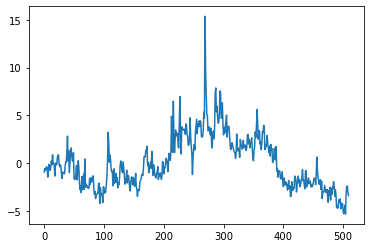

In [590]:
principalDf[3].plot()

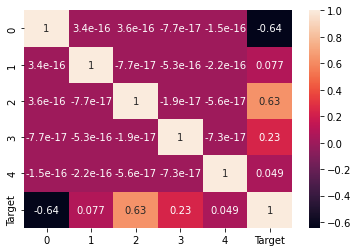

In [591]:
# correlation plot with target and pca
corrMatrix = principalDf.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [592]:
df_pca_train = principalDf[30:]
df_pca_test =  principalDf[:30]

In [593]:
# building linear model
predictors = df_pca_train[[0,1,2,3,4]]
predictors_cons = sm.add_constant(predictors)

fitted_linear = sm.OLS(df_pca_train['Target'], predictors_cons).fit()

fitted_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     506.6
Date:                Sun, 12 Jun 2022   Prob (F-statistic):          1.48e-187
Time:                        12:22:44   Log-Likelihood:                -161.69
No. Observations:                 480   AIC:                             335.4
Df Residuals:                     474   BIC:                             360.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4377      0.016    329.883      0.000       5.405       5.470
0             -0.1260      0.003    -38.173      0.000      -0.132      -0.119
1              0.0240      0.005      4.423      0.000       0.013       0.035
2              0.1682      0.007     24.941      0.000       0.155       0.181
3              0.0812      0.006     14.433      0.000       0.070       0.092
4              0.0253      0.007      3.399      0.001       0.011       0.040
==============================================================================
Omnibus:                        2.109   Durbin-Watson:                   0.291
Prob(Omnibus):                  0.348   Jarque-Bera (JB):                2.101
Skew:                           0.028   Prob(JB):                        0.350
Kurtosis:                       3.319   Cond. No.                         5.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [594]:
forecast_list = []
for col in df_pca_train.columns:
    forecast_list.append(pm.auto_arima(df_pca_train[col], seasonal = False))

In [595]:
test_volume_error = []
test_trade_error = []

In [596]:
# I'm a little sus of the output here
df_step_ahead_forecast = pd.DataFrame()

for col in df_pca_test.columns[:-1]:
    
    test_forecast = []
    
    forecast_model_col = forecast_list[col]
    
    for i in range(len(df_pca_test), 0, -1):
        
        tmp_forecast_model = forecast_model_col
        
        if (i == 30):
        
            test_forecast.append(tmp_forecast_model.predict(n_periods = 1)[0])
        else:
            
            tmp_forecast_model.update(df_pca_test[col][i:])

            test_forecast.append(tmp_forecast_model.predict(n_periods = 1)[0])
    
    df_step_ahead_forecast[col] = test_forecast

In [597]:
df_new_forecast = sm.add_constant(df_step_ahead_forecast)

pred_lm_forecast = fitted_linear.predict(df_new_forecast)

In [599]:
# mae for forecasted variables as predictors of the closed amount.
# 2 dollars is a pretty decent mae 
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)))

2.026101726698035

In [614]:
np.std(special.inv_boxcox(df_pca_test['Target'], fitted_lambda))

1.0029007373059866

In [600]:
# mape for the forecasted new dataset using one step ahead forecasts
# um, why in the is this a mape of 0.07...
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)) / special.inv_boxcox(df_pca_test['Target'], fitted_lambda))

0.07103508826823485

In [612]:
# checking to see the actual apple stock price
df_american = api.get_bars("AAL", TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df; df_american

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2020-01-02 05:00:00+00:00,28.98,29.2950,28.6500,29.09,6452335,38032,28.968802
2020-01-03 05:00:00+00:00,28.27,28.2900,27.3400,27.65,14020066,80365,27.774135
2020-01-06 05:00:00+00:00,27.19,27.4901,27.0800,27.32,6108646,36860,27.310304
2020-01-07 05:00:00+00:00,27.56,27.6800,27.0600,27.22,6197079,37665,27.285355
2020-01-08 05:00:00+00:00,27.10,28.0900,27.0700,27.84,10497339,56794,27.712617
...,...,...,...,...,...,...,...
2022-01-03 05:00:00+00:00,18.25,19.1800,18.2000,18.75,42880712,162129,18.782317
2022-01-04 05:00:00+00:00,19.20,19.4600,18.8504,19.02,29265201,119421,19.090006
2022-01-05 05:00:00+00:00,19.15,19.3850,18.5100,18.68,34344706,132794,18.920915


In [ ]:
# Now I'm going to focus on Mr.MacD 